<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/GNN%20model%20ECG%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet --upgrade gensim
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import gensim
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec

# Dataset prepare

In [2]:
# загружаем полный датасет
#raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=25000)
raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ArrayArrowDataECGgraph.csv', nrows=25000, sep=';')
raw_table_data.head(5)

<ipython-input-2-29dd8e705a9f>:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/ArrayArrowDataECGgraph.csv', nrows=25000, sep=';')


,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,13312271,30,40001422,6448421,0,12:31 PM,05.02.2011,Sinus rhythm,Left bundle branch block,NaN,...,60 Hz notch Baseline filter,923,40,144,180,322,614,71,-13,117
1,19289869,20,40001735,6108919,0,2:29 AM,13.06.2011,Sinus rhythm with occasional PACs,Left axis deviation,Left bundle branch block,...,60 Hz notch Baseline filter,800,40,110,184,316,612,63,-34,140
2,11372768,20,40001980,6632385,0,2:01 PM,01.07.2011,Accelerated junctional rhythm,Left bundle branch block,NaN,...,<not specified>,759,460,29999,499,633,930,32767,-32,100
3,14729395,30,40003136,6672155,0,8:52 PM,09.07.2011,Sinus rhythm,Possible anterior infarct - age undetermined,Inferior/lateral ST-T changes may be due to my...,...,60 Hz notch Baseline filter,612,40,182,212,314,580,70,-4,132
4,11933271,40,40003371,6037973,0,2:34 PM,08.04.2013,Sinus rhythm,Possible left atrial abnormality,Tall T waves - consider acute ischemia or hype...,...,60 Hz notch Baseline filter,612,40,128,172,250,506,58,-27,53


In [31]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = raw_table_data[(raw_table_data[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

full_df_filtered['report']

,report
0,Sinus rhythm Left bundle branch block Abnormal...
1,Sinus rhythm with occasional PACs Left axis de...
3,Sinus rhythm Possible anterior infarct - age u...
4,Sinus rhythm Possible left atrial abnormality ...
8,Sinus bradycardia. Normal ECG except for rate
...,...
24993,Sinus bradycardia Possible left anterior fasci...
24995,Sinus bradycardia with 1st degree A-V block Le...
24997,Sinus tachycardia Extensive T wave changes may...
24998,Sinus rhythm Septal T wave changes are nonspec...


In [32]:
#example of diagnosis tokenizing
print(full_df_filtered['report'][1].lower().split())

def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

get_sentence_embedding(full_df_filtered['report'][1])

['sinus', 'rhythm', 'with', 'occasional', 'pacs', 'left', 'axis', 'deviation', 'left', 'bundle', 'branch', 'block', 'abnormal', 'ecg']


array([ 0.44344833, -0.14724717, -0.10593463, -0.05292391,  0.31706646,
        0.02417236,  0.4104257 , -0.03249006,  0.26931533,  0.01984225,
       -0.14633216,  0.41353735,  0.17583415, -0.24837361, -0.25182673,
        0.9229919 , -0.15417504,  0.7891108 , -0.02065097,  0.49009252,
       -0.18534923,  0.12982121, -0.46908543,  0.00669736, -0.23125008,
        0.7697879 ,  0.46566492, -0.77077043,  0.17721975,  0.3260515 ,
       -0.11541394, -0.46610162, -0.03697931,  0.28543612,  0.5851822 ,
        0.29112142, -0.01432429, -0.04414814,  0.45220956, -0.5065946 ,
        0.00658869, -0.18838546,  0.68050236,  0.14086719,  0.2275329 ,
        0.6010734 , -0.36984143, -0.20315193,  0.4677411 , -1.2398052 ,
        0.03065318,  0.09369788, -0.27772337, -0.45149082, -0.07596308,
       -0.26150775,  0.08514917,  0.32545358,  0.5158379 ,  0.27319786,
       -0.25493178,  0.47498423, -0.055796  ,  0.01705526,  0.77234304,
        0.40875378,  0.30426964, -0.311331  ,  0.1240326 , -0.61

In [33]:
full_df_filtered['report'].describe()

,report
count,17703
unique,7160
top,Sinus rhythm Normal ECG
freq,3323


In [34]:
# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

,subject_id,Count_subj,study_id,cart_id,eeg_time,eeg_date,report,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,13312271,30,40001422,6448421,12:31 PM,05.02.2011,0.040291,923,40,144,180,322,614,71,-13,117,0
1,19289869,20,40001735,6108919,2:29 AM,13.06.2011,0.034630,800,40,110,184,316,612,63,-34,140,0
3,14729395,30,40003136,6672155,8:52 PM,09.07.2011,0.013889,612,40,182,212,314,580,70,-4,132,0
4,11933271,40,40003371,6037973,2:34 PM,08.04.2013,0.023168,612,40,128,172,250,506,58,-27,53,0
8,15726063,20,40006307,6920139,8:01 AM,25.11.2009,-0.016064,1034,40,154,216,308,646,50,59,69,1


In [35]:
# make new dataset from old columns
table_data = full_df_filtered[['subject_id','study_id','eeg_date','report','rr_interval','p_end','qrs_onset','qrs_end','t_end','p_axis','qrs_axis','t_axis','Healthy_Status']].copy()
table_data['eeg_date'] = pd.to_datetime(table_data['eeg_date'],dayfirst=True)
table_data = table_data.sort_values(by=['subject_id', 'eeg_date'])

#table_data = table_data.head(1000)

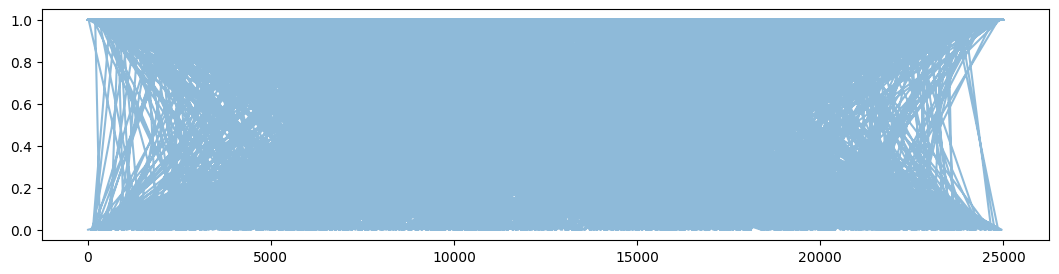

In [39]:
patient_visit_time_array_index = table_data['subject_id'].duplicated()
plt.figure(figsize=(13,3))
plt.plot(patient_visit_time_array_index, alpha = 0.5)

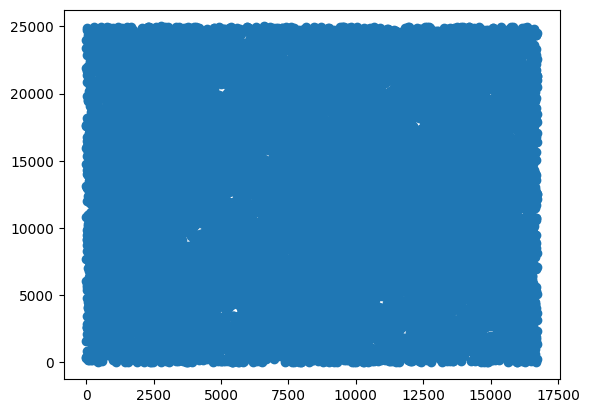

In [40]:

patient_visit_time_array_index = patient_visit_time_array_index[patient_visit_time_array_index[:]==True].index
plt.scatter(range(0,len(patient_visit_time_array_index)), patient_visit_time_array_index)

In [41]:
table_data.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,10002430,46776688,2011-01-08,0.002894,800,148,208,306,572,66,54,70,1
6030,10002430,42430320,2011-03-10,0.037392,714,140,230,350,636,47,63,33,0
21880,10002430,48702630,2012-03-09,0.024067,1034,164,198,316,674,-52,64,36,0
1601,10002430,40634706,2013-03-29,-0.013931,594,142,180,256,520,39,23,21,1
13125,10002430,45250519,2013-11-26,-0.010896,1071,176,268,410,706,33,-65,76,0


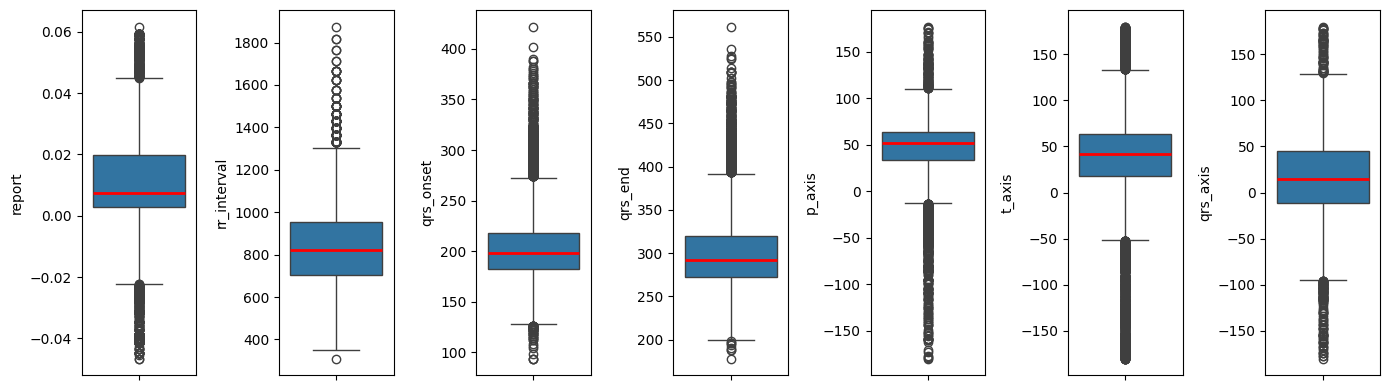

In [42]:
view_table_data = table_data[['report','rr_interval','qrs_onset','qrs_end','p_axis','t_axis','qrs_axis']]

n = view_table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=False)
for i in range(n):
    plt.sca(ax[i])
    col = view_table_data.columns[i]
    sns.boxplot(y = view_table_data.iloc[:,i],data=view_table_data, medianprops={"color": "r", "linewidth": 2})
    fig.tight_layout()

Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

In [45]:
from sklearn.preprocessing import LabelEncoder

# we need to encoder data
encoder = LabelEncoder()
columns_to_encode = list(set(table_data.columns) - {"subject_id","study_id"})
patient_visit_table = table_data
#ecg_table["eeg_date"] = encoder.fit_transform(ecg_table["eeg_date"])
for col in columns_to_encode:
    patient_visit_table[col] = encoder.fit_transform(patient_visit_table[col])

patient_visit_table.describe()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
count,1.770300e+04,1.770300e+04,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000,17703.000000
mean,1.499018e+07,4.501793e+07,1359.223239,2963.786816,75.490934,49.235610,50.379540,55.585663,100.403604,180.116477,164.162571,219.799638,0.279388
std,2.830020e+06,2.877138e+06,700.801934,2128.380224,17.444695,9.230378,16.143473,20.827120,30.930900,28.408823,40.845723,49.699325,0.448711
min,1.000243e+07,4.000142e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.253510e+07,4.253763e+07,776.500000,1489.000000,66.000000,44.000000,40.000000,42.000000,80.000000,167.000000,138.000000,197.000000,0.000000
50%,1.512751e+07,4.501460e+07,1357.000000,2207.000000,78.000000,50.000000,48.000000,52.000000,99.000000,186.000000,164.000000,221.000000,0.000000
75%,1.740923e+07,4.751539e+07,1953.000000,4695.500000,88.000000,55.000000,58.000000,66.000000,119.000000,198.000000,194.000000,243.000000,1.000000
max,1.998526e+07,4.995937e+07,2803.000000,7157.000000,119.000000,85.000000,143.000000,163.000000,233.000000,294.000000,313.000000,359.000000,1.000000


In [46]:
# define sources and target = edges fot graph

class_values = sorted(patient_visit_table["Healthy_Status"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}

subject_idx = {name: idx for idx, name in enumerate(sorted(patient_visit_table["subject_id"].unique()))}
patient_visit_table["subject_id"] = patient_visit_table["subject_id"].apply(lambda name: subject_idx[name])


study_idx = {name: idx for idx, name in enumerate(sorted(patient_visit_table["study_id"].unique()))}
patient_visit_table["study_id"] = patient_visit_table["study_id"].apply(lambda name: study_idx[name])

In [48]:
print('Number of class: ',class_values)
print('Total patient records: ', len(patient_visit_table['Healthy_Status']))
patient_visit_table['Healthy_Status'].sum()
patient_visit_table.head()

Number of class:  [0, 1]
Total patient records:  17703


,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,0,11911,459,1489,76,49,53,59,86,200,203,249,1
6030,0,4228,519,6734,67,45,64,81,118,181,212,212,0
21880,0,15434,884,5426,93,57,48,64,137,82,213,215,0
1601,0,1117,1269,421,50,46,39,34,60,173,172,200,1
13125,0,9287,1510,507,95,63,83,111,153,167,84,255,0


# Data Visualization as a Graph

In [49]:
#import os
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder

import networkx as nx

## edge end nodes vizualisation

In [50]:
# Находим дубликаты по 'subject_id'
uniq_patient_visit_table = table_data[table_data.duplicated(subset=['subject_id'], keep=False)]

# Сортируем для удобства (опционально)
uniq_patient_visit_table = uniq_patient_visit_table.sort_values(by='subject_id')
print(len(uniq_patient_visit_table))
uniq_patient_visit_table.head()

17703


,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,0,11911,459,1489,76,49,53,59,86,200,203,249,1
15940,0,11250,2668,1261,102,42,101,126,221,145,80,200,0
14763,0,10444,2349,3063,68,33,44,60,67,242,129,311,0
7709,0,5429,2140,2796,76,51,55,58,116,171,222,240,0
17692,0,12484,1842,1376,78,48,50,46,93,211,234,258,1


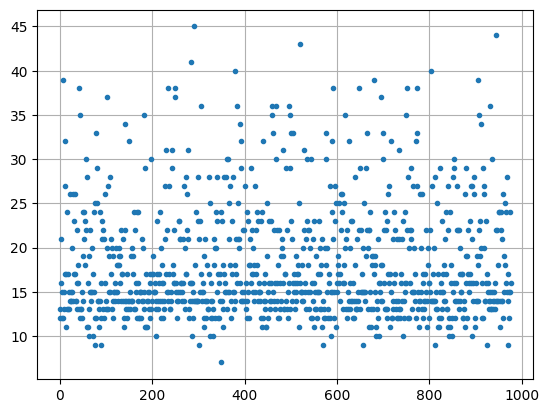

In [51]:
subject_freq = uniq_patient_visit_table.groupby('subject_id')['study_id'].nunique()
plt.plot(subject_freq,'.')
plt.grid()

In [52]:
subject_freq

,study_id
subject_id,
0,12
1,13
2,21
3,16
4,12
...,...
972,12
973,15
974,15


In [ ]:
max(pd.unique(uniq_patient_visit_table['subject_id']))

976

In [53]:
one_patient_df = uniq_patient_visit_table[uniq_patient_visit_table["subject_id"] == 1]
one_patient_df = one_patient_df.sort_values('eeg_date')
one_patient_df

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
11898,1,8394,168,3531,69,44,57,65,102,180,239,103,0
10821,1,7625,773,2427,87,51,50,54,99,210,216,143,0
390,1,279,1348,4615,68,38,35,72,98,191,196,169,0
17631,1,12443,1604,1926,85,47,32,35,84,165,145,296,0
21385,1,15080,1757,3458,84,63,47,50,117,201,206,232,0
5800,1,4058,1815,6765,46,48,38,40,52,213,226,231,0
1680,1,1178,1840,304,103,24,33,32,97,193,187,215,1
16773,1,11834,1944,3503,57,58,57,62,90,165,174,192,0
22872,1,16165,2037,3956,83,60,48,46,113,177,154,222,0
18166,1,12818,2159,3527,52,32,33,30,49,169,152,180,0


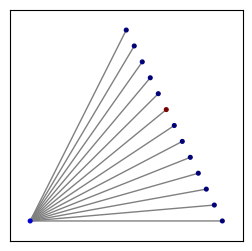

In [54]:
graph_model = pd.DataFrame(
    {
        "source": one_patient_df['subject_id'],
        "target": one_patient_df['report'],
        "edge_key": one_patient_df['eeg_date'],
        "weight": one_patient_df['report'],
        "status": one_patient_df['Healthy_Status'],
    }
)

color_map = []

G = nx.from_pandas_edgelist(
    graph_model,
    edge_key="edge_key",
    edge_attr=["weight", "status"],
    create_using=nx.MultiGraph(),
)

for node in G.nodes():
    # Example: use the average status of all connected edges
    edge_statuses = [data['status'] for _, _, data in G.edges(node, data=True)]
    avg_status = sum(edge_statuses)/len(edge_statuses) if edge_statuses else 0
    color_map.append(avg_status)

plt.figure(figsize=(3, 3))
nx.draw_networkx(
    G,
    pos=nx.planar_layout(G),
    node_size=7,
    font_size=0,
    edge_color='grey',
    node_color=color_map,
    cmap=plt.cm.jet
)
plt.show()

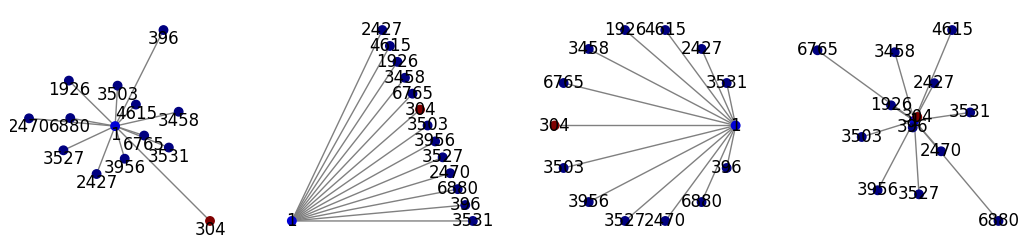

In [55]:
plt.figure(figsize=(13,3))
# plt.subplot() will create "sub-plots" in one canvas
# Now we are telling matplotlib to give us a 2x2 subplot canvas
plt.subplot(141)  # first subplot
nx.draw_spring(G, with_labels=True, node_color=color_map, cmap=plt.cm.jet, verticalalignment='top', node_size=37, edge_color='grey')
plt.subplot(142) # second subplot
nx.draw_planar(G, with_labels=True, node_color=color_map, cmap=plt.cm.jet,node_size=37, edge_color='grey')
plt.subplot(143) # third subplot
nx.draw_circular(G, with_labels=True, node_color=color_map, cmap=plt.cm.jet,node_size=37, edge_color='grey')
plt.subplot(144) # last subplot
nx.draw_kamada_kawai(G, with_labels=True, node_color=color_map, cmap=plt.cm.jet,node_size=37, edge_color='grey')

In [56]:
#duplicated_rows=duplicated_rows.head(len(duplicated_rows)//2)
#duplicated_rows = duplicated_rows.sample(3000)
graph_model = pd.DataFrame(
    {
        "source": uniq_patient_visit_table['subject_id'],
        "target": uniq_patient_visit_table['study_id'],
        "edge_key": uniq_patient_visit_table['eeg_date'],
        "weight": uniq_patient_visit_table['report'],
        "status": uniq_patient_visit_table['Healthy_Status'],
    }
)
print(len(graph_model))

17703


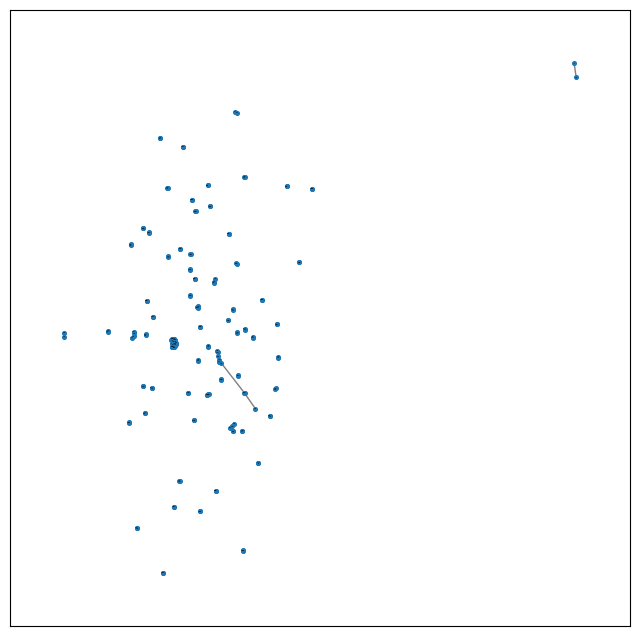

In [174]:
G = nx.from_pandas_edgelist(
    graph_model,
    edge_key="edge_key",
    edge_attr=["weight", "status"],
    create_using=nx.MultiGraph(),
)

color_map = graph_model['status'].to_numpy()
plt.figure(figsize=(8, 8))
nx.draw_networkx(G, pos=nx.spring_layout(G),
                 node_size=7, font_size = 0,edge_color ='grey',
                 #node_color=color_map,
                 )

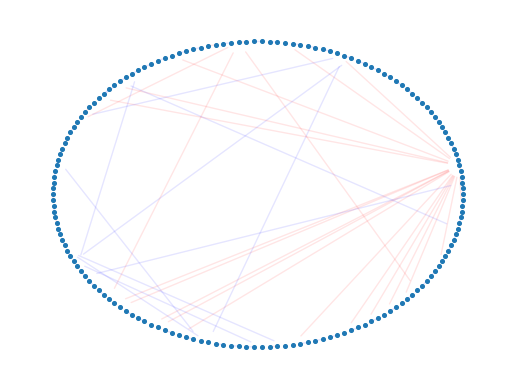

In [175]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] <= 0.5]

pos = nx.circular_layout(G)#, seed=13)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=7)

# edges
nx.draw_networkx_edges(G, pos, alpha=0.1, edgelist=elarge, width=1, edge_color="r")
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=1, alpha=0.1, edge_color="b", style="solid"
)


ax = plt.gca()
#ax.margins(0.08)
plt.axis("off")
#plt.tight_layout()
plt.show()


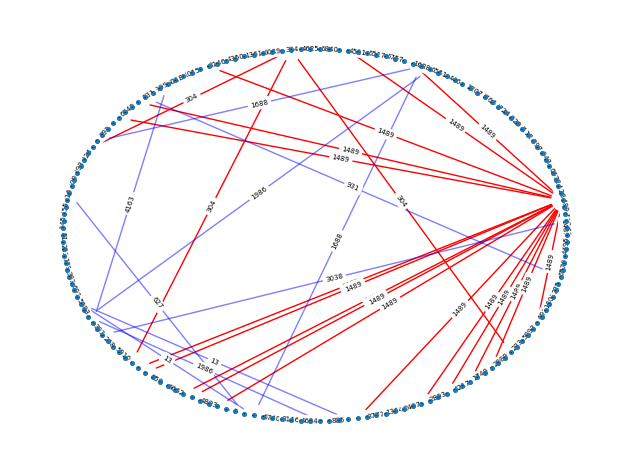

In [176]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] <= 0.5]

pos = nx.circular_layout(G)#, seed=13)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=7)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=1, edge_color="r")
nx.draw_networkx_edges(
    G, pos, edgelist=esmall, width=1, alpha=0.5, edge_color="b", style="solid"
)

# node labels
nx.draw_networkx_labels(G, pos, font_size=0, font_family="sans-serif")
# edge weight labels
edge_labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=5)

ax = plt.gca()
#ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()


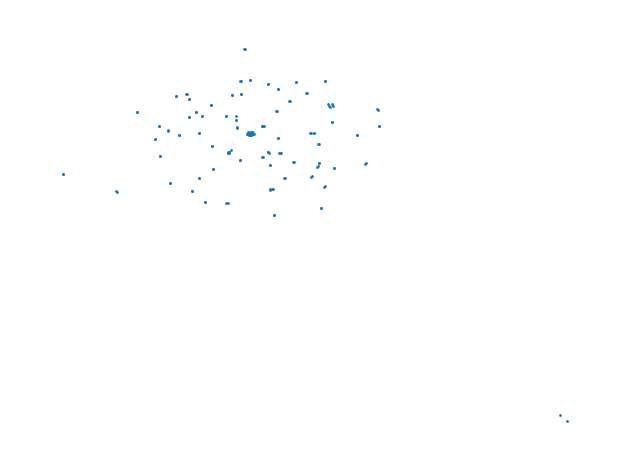

In [177]:
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] > 0.5]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["status"] <= 0.5]

pos = nx.spring_layout(G)#, seed=13)  # positions for all nodes - seed for reproducibility

# nodes
nx.draw_networkx_nodes(G, pos, node_size=1)

# edges
nx.draw_networkx_edges(G, pos, edgelist=elarge, width=0.5, alpha=0.1, edge_color="r")
nx.draw_networkx_edges(G, pos, edgelist=esmall, width=0.5, alpha=0.1, edge_color="b", style="dashed")

# node labels
#nx.draw_networkx_labels(G, pos, font_size=0, font_family="sans-serif")
# edge weight labels
#edge_labels = nx.get_edge_attributes(G, "weight")
#nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=5)

ax = plt.gca()
#ax.margins(0.08)
plt.axis("off")
plt.tight_layout()
plt.show()

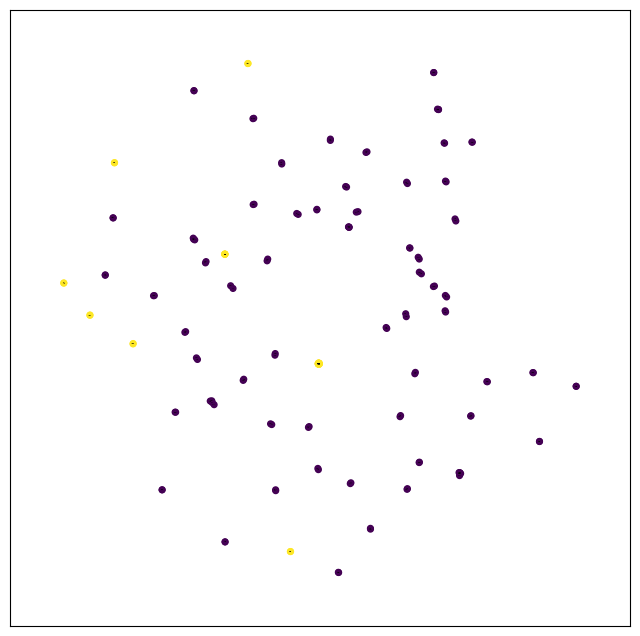

In [178]:
# If you want to color nodes based on some aggregation of their connected edges' status
color_map = []
for node in G.nodes():
    # Example: use the average status of all connected edges
    edge_statuses = [data['status'] for _, _, data in G.edges(node, data=True)]
    avg_status = sum(edge_statuses)/len(edge_statuses) if edge_statuses else 0
    color_map.append(avg_status)

plt.figure(figsize=(8, 8))
nx.draw_networkx(
    G,
    pos=nx.kamada_kawai_layout(G),
    node_size=17,
    font_size=0,
    edge_color='grey',
    node_color=color_map,
    cmap=plt.cm.viridis
)
plt.show()

# Model: GNN vs MLP (Graph Neural Network / Feed forward network)

In [59]:
import random
patient_visit_table.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,0,11911,459,1489,76,49,53,59,86,200,203,249,1
6030,0,4228,519,6734,67,45,64,81,118,181,212,212,0
21880,0,15434,884,5426,93,57,48,64,137,82,213,215,0
1601,0,1117,1269,421,50,46,39,34,60,173,172,200,1
13125,0,9287,1510,507,95,63,83,111,153,167,84,255,0


## example of dataframe to graph transform

In [ ]:
#duplicated_rows=duplicated_rows.head(len(duplicated_rows)//2)
#duplicated_rows = duplicated_rows.sample(3000)
graph_model = pd.DataFrame(
    {
        "source": patient_visit_table['subject_id'],
        "target": patient_visit_table['study_id'],
        "edge_key": patient_visit_table['eeg_date'],
        "weight": patient_visit_table['report'],
        "status": patient_visit_table['Healthy_Status'],
    }
)
print(len(graph_model))

In [ ]:
#class_values = sorted(ecg_table["Healthy_Status"].unique())
class_values = sorted(graph_model["status"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
class_values

#feature_names = list(set(ecg_table.columns) - {"subject_id", "study_id", "Healthy_Status"})
feature_names = list(set(graph_model.columns) - {"status"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
#y_train = train_data["Healthy_Status"]
#y_test = test_data["Healthy_Status"]
y_train = train_data["status"]
y_test = test_data["status"]

[0, 1]

In [ ]:
train_data, test_data = [], []

#for _, group_data in ecg_table.groupby("subject_id"):
for _, group_data in graph_model.groupby("source"):
#for _, group_data in graph_model.groupby("source"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (2357, 5)
Test data shape: (643, 5)


## Vanila MLP NN

In [60]:
train_data, test_data = [], []

random.seed(13)
for _, group_data in patient_visit_table.groupby("subject_id"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (14165, 13)
Test data shape: (3538, 13)


In [61]:
feature_names = list(set(patient_visit_table.columns) - {"subject_id", "study_id", "eeg_date", "Healthy_Status"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["Healthy_Status"]
y_test = test_data["Healthy_Status"]

In [62]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

In [63]:
def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")

In [64]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 50
batch_size = 256


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

Model: "baseline"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_features      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block1          │ (None, 32)        │      1,540 │ input_features[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block2          │ (None, 32)        │      2,368 │ ffn_block1[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection2    │ (None, 32)        │          0 │ ffn_block1[0][0], │
│ (Add)               │                   │            │ ffn_block2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block3          │ (None, 32)        │      2,368 │ skip_connection2… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection3    │ (None, 32)        │          0 │ skip_connection2… │
│ (Add)               │                   │            │ ffn_block3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block4          │ (None, 32)        │      2,368 │ skip_connection3… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection4    │ (None, 32)        │          0 │ skip_connection3… │
│ (Add)               │                   │            │ ffn_block4[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_block5          │ (None, 32)        │      2,368 │ skip_connection4… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ skip_connection5    │ (None, 32)        │          0 │ skip_connection4… │
│ (Add)               │                   │            │ ffn_block5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ logits (Dense)      │ (None, 2)         │         66 │ skip_connection5… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,078 (43.27 KB)

 Trainable params: 10,484 (40.95 KB)

 Non-trainable params: 594 (2.32 KB)

In [65]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [75]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train (loss)", "test (loss)"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.grid()

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train (acc)", "test (val_acc)"], loc="lower right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    ax2.grid()

    #plt.grid()
    plt.show()

In [67]:
history = run_experiment(baseline_model, x_train, y_train)

Epoch 1/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 27ms/step - acc: 0.6531 - loss: 0.9411 - val_acc: 0.7181 - val_loss: 0.8177
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - acc: 0.7392 - loss: 0.4797 - val_acc: 0.7181 - val_loss: 0.6012
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.7536 - loss: 0.4439 - val_acc: 0.7981 - val_loss: 0.3593
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - acc: 0.7575 - loss: 0.4337 - val_acc: 0.8438 - val_loss: 0.3323
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.7684 - loss: 0.4180 - val_acc: 0.8631 - val_loss: 0.3146
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.7767 - loss: 0.4129 - val_acc: 0.8504 - val_loss: 0.3145
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.7784 - loss: 0.4125 - val_acc: 0.8456 - val_loss: 0.3166
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.7905 - loss: 0.3996 - val_acc: 0.8508 - val_loss: 0.3116
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - acc: 0.781

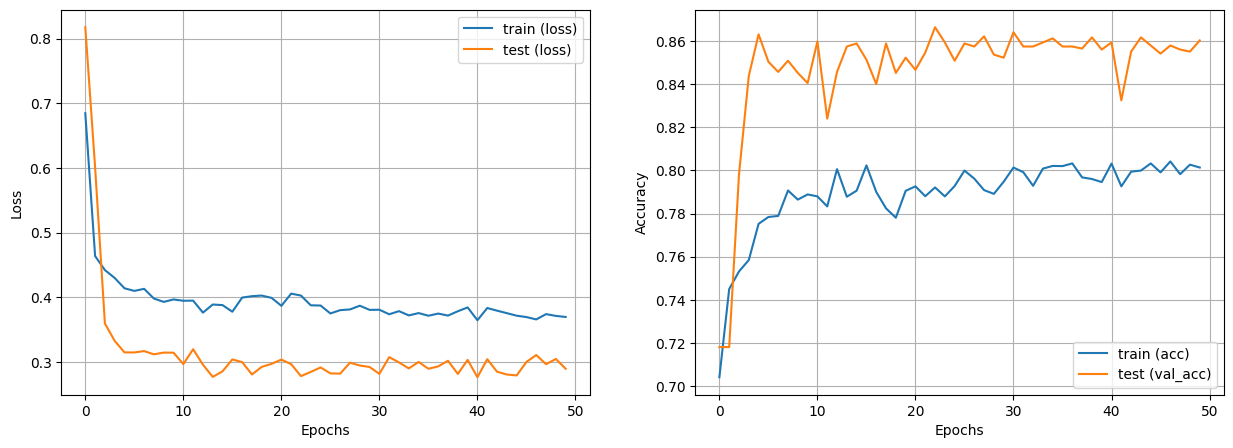

In [76]:
display_learning_curves(history)

In [69]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 86.74%


In [77]:

def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


In [78]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
Instance 1:
- 0: 99.84%
- 1: 0.16%
Instance 2:
- 0: 99.84%
- 1: 0.16%


## Graph Neural Network

In [157]:
patient_visit_table.head()

,subject_id,study_id,eeg_date,report,rr_interval,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
16869,0,11911,459,1489,76,49,53,59,86,200,203,249,1
6030,0,4228,519,6734,67,45,64,81,118,181,212,212,0
21880,0,15434,884,5426,93,57,48,64,137,82,213,215,0
1601,0,1117,1269,421,50,46,39,34,60,173,172,200,1
13125,0,9287,1510,507,95,63,83,111,153,167,84,255,0


In [158]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = patient_visit_table[["subject_id", "study_id"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])*patient_visit_table['report']/max(patient_visit_table['report'])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    patient_visit_table.sort_values("subject_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)

# Create graph info tuple with node_features, edges, and edge_weights.
graph_patient_visits = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

Edges shape: (2, 17703)
Nodes shape: (17703, 10)


In [159]:
graph_patient_visits

(<tf.Tensor: shape=(17703, 10), dtype=float32, numpy=
 array([[  59.,   49.,  203., ..., 1489.,  200.,   86.],
        [ 126.,   42.,   80., ..., 1261.,  145.,  221.],
        [  60.,   33.,  129., ..., 3063.,  242.,   67.],
        ...,
        [  75.,   58.,   68., ..., 2545.,  180.,  124.],
        [  70.,   48.,  129., ..., 1201.,  196.,  108.],
        [  67.,   47.,  146., ...,  304.,  190.,  141.]], dtype=float32)>,
 array([[    0,     0,     0, ...,   976,   976,   976],
        [11911,  4228, 15434, ...,  2584,   202,   970]]),
 <tf.Tensor: shape=(17703,), dtype=float32, numpy=
 array([0.20804806, 0.94089705, 0.7581389 , ..., 0.8810954 , 0.35559592,
        0.0424759 ], dtype=float32)>)

In [160]:
class_values = sorted(patient_visit_table["Healthy_Status"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
class_values

[0, 1]

In [161]:
train_data, test_data = [], []

random.seed(13)
for _, group_data in patient_visit_table.groupby("subject_id"):
    # Select around 80% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.8
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

Train data shape: (14044, 13)
Test data shape: (3659, 13)


In [162]:
feature_names = list(set(patient_visit_table.columns) - {"subject_id", "study_id", "Healthy_Status"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["Healthy_Status"]
y_test = test_data["Healthy_Status"]

In [163]:
def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
        x = layers.GRU(
            units=units,
            activation="tanh",
            recurrent_activation="sigmoid",
            return_sequences=True,
            dropout=dropout_rate,
            return_state=False,
            recurrent_dropout=dropout_rate,
        )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


"""
### Implement a graph neural network node classifier

The GNN classification model follows the [Design Space for Graph Neural Networks](https://arxiv.org/abs/2011.08843) approach,
as follows:

1. Apply preprocessing using FFN to the node features to generate initial node representations.
2. Apply one or more graph convolutional layer, with skip connections,  to the node representation
to produce node embeddings.
3. Apply post-processing using FFN to the node embeddings to generate  the final node embeddings.
4. Feed the node embeddings in a Softmax layer to predict the node class.

Each graph convolutional layer added captures information from a further level of neighbours.
However, adding many graph convolutional layer can cause oversmoothing, where the model
produces similar embeddings for all the nodes.

Note that the `graph_info` passed to the constructor of the Keras model, and used as a *property*
of the Keras model object, rather than input data for training or prediction.
The model will accept a **batch** of `node_indices`, which are used to lookup the
node features and neighbours from the `graph_info`.
"""


class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="mean",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


In [164]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 50
batch_size = 256

gnn_model = GNNNodeClassifier(
    graph_info=graph_patient_visits,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

gnn_model.summary()

Model: "gnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv1 (GraphConvLayer)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ graph_conv2 (GraphConvLayer)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ postprocess (Sequential)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logits (Dense)                  │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [165]:
x_train = train_data.report.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - acc: 0.6243 - loss: 23.6401 - val_acc: 0.7162 - val_loss: 0.5988
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 213ms/step - acc: 0.8778 - loss: 0.3600 - val_acc: 0.8918 - val_loss: 0.3160
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - acc: 0.8986 - loss: 0.2777 - val_acc: 0.8942 - val_loss: 0.2863
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - acc: 0.8981 - loss: 0.2665 - val_acc: 0.8908 - val_loss: 0.2534
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 189ms/step - acc: 0.9100 - loss: 0.2345 - val_acc: 0.9445 - val_loss: 0.1723
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - acc: 0.9549 - loss: 0.1353 - val_acc: 0.9464 - val_loss: 0.1713
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 219ms/step - acc: 0.9553 - loss: 0.1293 - val_acc: 0.9535 - val_loss: 0.1732
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - acc: 0.9609 - loss: 0.1447 - val_acc: 0.9639 - val_loss: 0.1570
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/

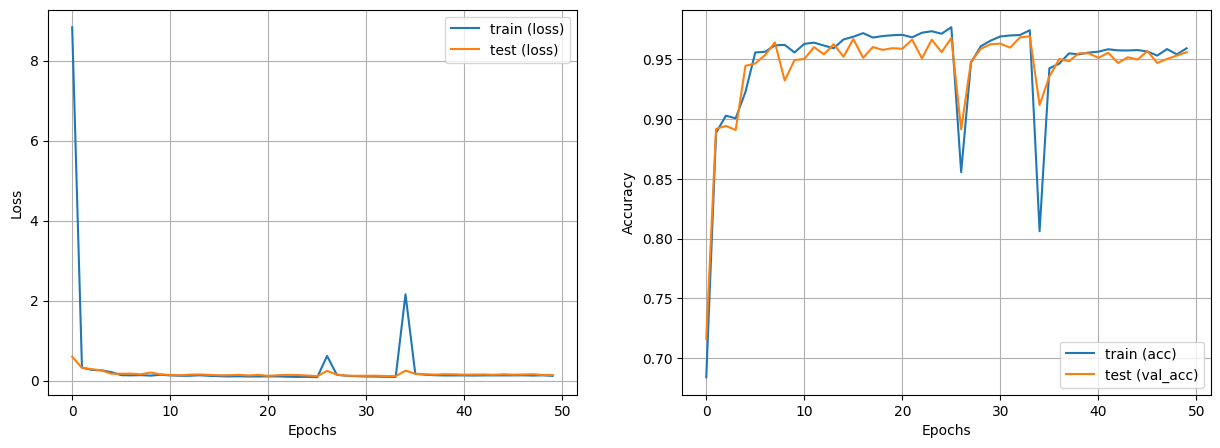

In [166]:
display_learning_curves(history)

In [167]:
x_test = test_data.report.to_numpy()
#x_test = test_data.source.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 97.27%


In [168]:
#new_instances = generate_random_instances(num_classes)
token_probability = x_train.mean(axis=0)
instances = []
for _ in range(3):
        probabilities = np.random.uniform(size = num_features)
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)
new_instances = instances

In [169]:
node_features.shape

TensorShape([17703, 10])

In [170]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]


## Create a node features array of shape [num_nodes, num_features].
##node_features = tf.cast(
##    ecg_table.sort_values("subject_id")[feature_names].to_numpy(),
##    dtype=tf.dtypes.float32)

new_node_features = np.concatenate([node_features, new_instances])

# Second we add the M edges (it's a kind of next patient visits) from each new node to a set
# of existing nodes in a particular subject

new_node_indices = [i + num_nodes for i in range(3)]

new_patient_visits = []
for subject_idx, group in patient_visit_table.groupby("Healthy_Status"):
    subject_patient = list(group.subject_id)
    # Select random x nodes specific patient.
    selected_node_indices1 = np.random.choice(subject_patient, 3)
    # Select random y nodes from any subject as a patient (where y < x).
    selected_node_indices2 = np.random.choice(list(patient_visit_table.subject_id), 2)
    # Merge the selected node indices.
    selected_node_indices = np.concatenate(
        [selected_node_indices1, selected_node_indices2], axis=0
    )
    # Create edges between a patient visits idx and the selected subject.
    patient_indx = new_node_indices[subject_idx]
    for old_patient_visit_idx in selected_node_indices:
        new_patient_visits.append([patient_indx, old_patient_visit_idx])


new_patient_visits = np.array(new_patient_visits).T
new_edges = np.concatenate([edges, new_patient_visits], axis=1)

In [171]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Original node_features shape: (17703, 10)
Original edges shape: (2, 17703)
New node_features shape: (17706, 10)
New edges shape: (2, 17713)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 881ms/step
Instance 1:
- 0: 92.6%
- 1: 7.4%
Instance 2:
- 0: 92.53%
- 1: 7.47%
Instance 3:
- 0: 99.43%
- 1: 0.57%


In [172]:
view_ecg_table = ecg_table.sample(n=100)

graph_model = pd.DataFrame(
    {
        "source": view_ecg_table['subject_id'],
        "target": view_ecg_table['report'],
        "edge_key": view_ecg_table['eeg_date'],
        "weight": view_ecg_table['report'],
        "status": view_ecg_table['Healthy_Status'],
    }
)

graph_model.head()

,source,target,edge_key,weight,status
8463,578,5638,704,5638,0
1456,479,4710,305,4710,0
1697,882,1489,2302,1489,1
7716,903,6128,2319,6128,0
22721,717,6672,611,6672,0


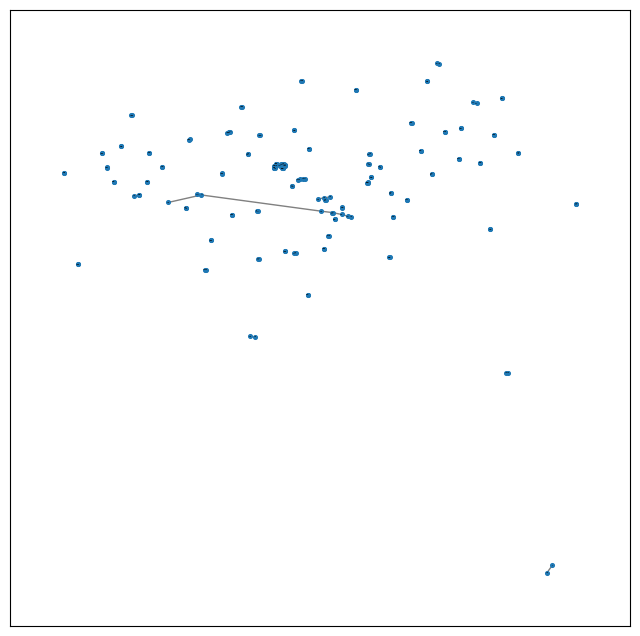

In [173]:

G = nx.from_pandas_edgelist(
    graph_model,
    edge_key="edge_key",
    edge_attr=["weight", "status"],
    create_using=nx.MultiGraph(),
)

plt.figure(figsize=(8, 8))

nx.draw_networkx(G, pos=nx.spring_layout(G), node_size=7, font_size = 1,edge_color ='grey')



# Torch framework graph GCN model

In [ ]:
!pip install -q torch_geometric

In [ ]:
import torch
torchversion = torch.__version__

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Dataset
from torch_geometric.utils import to_networkx

import networkx as nx

In [ ]:
import random

In [ ]:
class CustomGraphDataset(Dataset):
    def __init__(self, num_graphs=10, num_nodes_per_graph=20,
                 num_features=15, num_classes=2, train_ratio=0.8,
                 seed=42):
        """
        Optimized in-memory graph dataset without file I/O.

        Args:
            num_graphs: Number of graphs to generate
            num_nodes_per_graph: Nodes per graph
            num_features: Features per node
            num_classes: Number of classes
            train_ratio: Ratio of training nodes (0-1)
            seed: Random seed for reproducibility
        """
        super().__init__()
        self._num_graphs = num_graphs
        self._num_nodes = num_nodes_per_graph
        self._num_features = num_features
        self._num_classes = num_classes
        self._train_ratio = train_ratio  # Store as protected attribute
        self._seed = seed

        # Set random seeds
        torch.manual_seed(seed)
        np.random.seed(seed)

        # Generate all graphs upfront
        self.graphs = [self._generate_graph(i) for i in range(num_graphs)]

    @property
    def train_ratio(self):
        """Public accessor for train_ratio"""
        return self._train_ratio

    def _generate_graph(self, graph_idx):
        """Generate a single graph with all required attributes."""
        # Node features
        x = torch.rand(self.num_nodes, self.num_features)

        # Edge connections (small-world)
        edge_index = []
        for j in range(self.num_nodes):
            for k in range(random.randint(0,5)):
                edge_index.append([j, (j + k) % self.num_nodes])
                edge_index.append([(j + k) % self.num_nodes, j])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

        # Class labels (balanced)
        y = torch.tensor([i % self.num_classes for i in range(self.num_nodes)],
                        dtype=torch.long)
        y = y[torch.randperm(self.num_nodes)]

        # Train/test masks
        indices = torch.arange(self.num_nodes)
        train_idx, test_idx = train_test_split(
            indices,
            test_size=1-self.train_ratio,  # Now properly accessible
            random_state=self._seed + graph_idx,
            stratify=y.numpy()
        )
        #val_idx=test_idx

        train_idx, val_idx = train_test_split(
            train_idx,
            test_size=1-self.train_ratio,  # Now properly accessible
            random_state=self._seed + graph_idx,
         #   stratify=y.numpy()
        )
        #val_idx=test_idx


        train_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(self.num_nodes, dtype=torch.bool)
        train_mask[train_idx] = True
        test_mask[test_idx] = True
        val_mask[val_idx] = True


        # Verify we have actual training samples
        assert train_mask.sum() > 0, "No training nodes!"
        assert test_mask.sum() > 0, "No test nodes!"

        return Data(
            x=x,
            edge_index=edge_index,
            y=y,
            train_mask=train_mask,
            test_mask=test_mask,
            val_mask=val_mask,
            num_classes=self.num_classes
        )

    @property
    def num_graphs(self):
        return self._num_graphs

    @property
    def num_nodes(self):
        return self._num_nodes

    @property
    def num_features(self):
        return self._num_features

    @property
    def num_classes(self):
        return self._num_classes

    def len(self):
        return self.num_graphs

    def get(self, idx):
        return self.graphs[idx]

    def __repr__(self):
        return (f'{self.__class__.__name__}({len(self)}, '
                f'nodes={self.num_nodes}, '
                f'features={self.num_features}, '
                f'classes={self.num_classes}, '
                f'train_ratio={self.train_ratio})')

In [ ]:
dataset = CustomGraphDataset(
        num_graphs=10,
        num_nodes_per_graph=45,
        num_features=13,
        num_classes=2,
        train_ratio=0.7
    )

print(f"Created dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of classes: {dataset.num_classes}")

Created dataset: CustomGraphDataset(10, nodes=45, features=13, classes=2, train_ratio=0.7)
Number of graphs: 10
Number of classes: 2


In [ ]:
data=dataset[0]

In [ ]:
data.y

tensor([0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0])

In [ ]:
    # Examine first graph
sample = dataset[0]
print("\nSample graph info:")
print(f"Nodes: {sample.num_nodes}")
print(f"Edges: {sample.num_edges}")
print(f"Features: {sample.num_features}")
print(f"Classes present: {torch.unique(sample.y)}")


Sample graph info:
Nodes: 45
Edges: 208
Features: 13
Classes present: tensor([0, 1])


In [ ]:

print("\nClass distribution:")
for cls in range(dataset.num_classes):
  print(f"Class {cls}: {torch.sum(sample.y == cls).item()} nodes")

print("\nTrain/test split:")
print(f"Training nodes: {sample.train_mask.sum().item()}")
print(f"Test nodes: {sample.test_mask.sum().item()}")

    # Verify class balance in splits
print("\nClass distribution in training set:")
for cls in range(dataset.num_classes):
  train_nodes = torch.sum((sample.y == cls) & sample.train_mask).item()
  print(f"Class {cls}: {train_nodes} nodes")

print("\nClass distribution in test set:")
for cls in range(dataset.num_classes):
  test_nodes = torch.sum((sample.y == cls) & sample.test_mask).item()
  print(f"Class {cls}: {test_nodes} nodes")



Class distribution:
Class 0: 23 nodes
Class 1: 22 nodes

Train/test split:
Training nodes: 21
Test nodes: 14

Class distribution in training set:
Class 0: 10 nodes
Class 1: 11 nodes

Class distribution in test set:
Class 0: 7 nodes
Class 1: 7 nodes


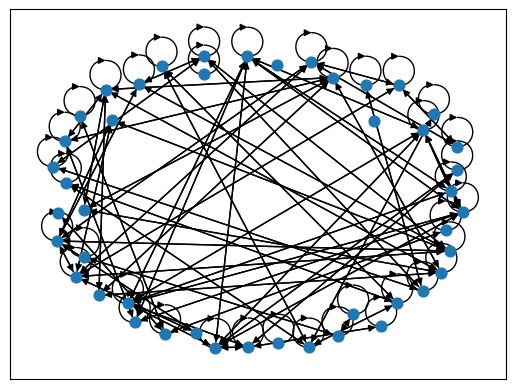

In [ ]:
networkX_graph = to_networkx(sample, node_attrs=["x"])


# Draw the graph
pos = nx.spring_layout(networkX_graph, k=13)
nx.draw_networkx(
    networkX_graph,
    pos=pos,
    with_labels=False,
    node_size=60,
)
plt.show()


In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 350

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [ ]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 5, dataset.num_classes)
#gcn = GCN(1, 16, 1)

print(gcn)


GCN(
  (gcn1): GCNConv(13, 5)
  (gcn2): GCNConv(5, 2)
)
CPU times: user 4.05 ms, sys: 0 ns, total: 4.05 ms
Wall time: 5.38 ms


In [ ]:
# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

Epoch   0 | Train Loss: 0.709 | Train Acc:  57.14% | Val Loss: 0.65 | Val Acc: 50.00%
Epoch  10 | Train Loss: 0.712 | Train Acc:  47.62% | Val Loss: 0.69 | Val Acc: 40.00%
Epoch  20 | Train Loss: 0.729 | Train Acc:  47.62% | Val Loss: 0.71 | Val Acc: 40.00%
Epoch  30 | Train Loss: 0.664 | Train Acc:  52.38% | Val Loss: 0.70 | Val Acc: 40.00%
Epoch  40 | Train Loss: 0.659 | Train Acc:  71.43% | Val Loss: 0.69 | Val Acc: 50.00%
Epoch  50 | Train Loss: 0.678 | Train Acc:  57.14% | Val Loss: 0.68 | Val Acc: 60.00%
Epoch  60 | Train Loss: 0.710 | Train Acc:  33.33% | Val Loss: 0.70 | Val Acc: 40.00%
Epoch  70 | Train Loss: 0.635 | Train Acc:  61.90% | Val Loss: 0.71 | Val Acc: 30.00%
Epoch  80 | Train Loss: 0.707 | Train Acc:  52.38% | Val Loss: 0.71 | Val Acc: 50.00%
Epoch  90 | Train Loss: 0.662 | Train Acc:  76.19% | Val Loss: 0.65 | Val Acc: 70.00%
Epoch 100 | Train Loss: 0.654 | Train Acc:  76.19% | Val Loss: 0.67 | Val Acc: 40.00%
Epoch 110 | Train Loss: 0.752 | Train Acc:  57.14% | V

In [ ]:
from sklearn.manifold import TSNE

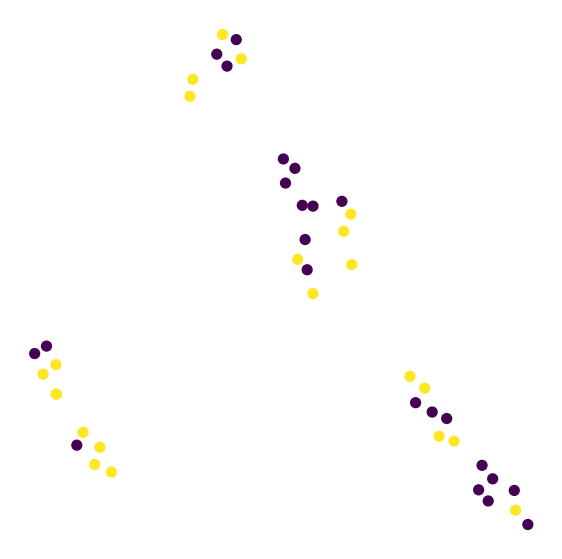

In [ ]:
# Get embeddings
h, _ = gcn(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, perplexity=5.0, learning_rate='auto', init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(7, 7))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

# Old ECG graph visualisation

In [ ]:
edge_index = torch.from_numpy(graph_model[["source", "target"]].to_numpy())
#node_features = torch.from_numpy(np.array(graph_model["weight"].tolist()))
node_features = torch.from_numpy(np.array(graph_model["weight"].to_numpy()))

#label = torch.from_numpy(np.array(graph_model["status"].tolist()))
label = torch.from_numpy(graph_model[["status"]].to_numpy())

edge_attr = torch.from_numpy(graph_model[["weight"]].to_numpy())

#data = Data(x=x, edge_index=edge_index.T)
data = Data(x=node_features,
            #edge_index=edge_index,
            edge_index=edge_index.t().contiguous(),
            edge_attr=edge_attr,
            y=label, #you can add more arguments as you like
                    )
data
#data.num_features

Data(x=[100], edge_index=[2, 100], edge_attr=[100, 1], y=[100, 1])

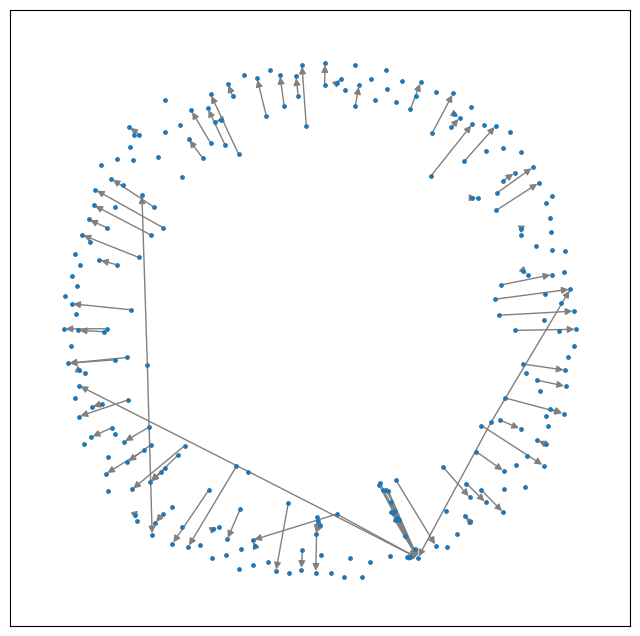

In [ ]:
graph = to_networkx(data, node_attrs=["x"], edge_attrs=["edge_attr"])
# Draw the graph

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(graph)#, k=2)
nx.draw_networkx(
    graph,
    pos=pos,
    with_labels=False,
    edge_color='grey',
    node_size=6,
)
plt.show()

In [ ]:
G.edges(data=True)

MultiEdgeDataView([(699, 5357, {'weight': 5357, 'status': 0}), (910, 5799, {'weight': 5799, 'status': 0}), (128, 5499, {'weight': 5499, 'status': 0}), (436, 6320, {'weight': 6320, 'status': 0}), (883, 382, {'weight': 382, 'status': 0}), (928, 1441, {'weight': 1441, 'status': 0}), (849, 1821, {'weight': 1821, 'status': 1}), (1821, 953, {'weight': 1821, 'status': 1}), (1821, 313, {'weight': 1821, 'status': 1}), (1821, 597, {'weight': 1821, 'status': 1}), (1821, 825, {'weight': 1821, 'status': 1}), (1821, 279, {'weight': 1821, 'status': 1}), (1821, 580, {'weight': 1821, 'status': 1}), (1821, 609, {'weight': 1821, 'status': 1}), (1821, 945, {'weight': 1821, 'status': 1}), (1821, 164, {'weight': 1821, 'status': 1}), (1821, 761, {'weight': 1821, 'status': 1}), (1821, 611, {'weight': 1821, 'status': 1}), (1821, 384, {'weight': 1821, 'status': 1}), (1821, 475, {'weight': 1821, 'status': 1}), (1821, 36, {'weight': 1821, 'status': 1}), (1821, 764, {'weight': 1821, 'status': 1}), (1821, 631, {'we